# `l2hmc`-qcd

- For 4D $SU(3)$ @ $\beta = 6.0$, $\langle U_{P}\rangle \approx 0.6$

In [1]:
!unset TF_XLA_FLAGS KMP_SETTINGS KMP_AFFINITY KMP_BLOCKTIME

In [2]:
# automatically detect and reload local changes to modules
%load_ext autoreload
%autoreload 2

# unset verbose TF XLA Flags
!unset TF_XLA_FLAGS
!unset KMP_AFFINITY KMP_SETTINGS

import os
from __future__ import absolute_import, print_function, annotations, division

import hydra
import torch
import tensorflow as tf
tf.config.run_functions_eagerly(True)
import numpy as np

from l2hmc.main import setup, setup_tensorflow, setup_torch

os.environ['OMP_NUM_THREADS'] = '8'

_ = setup_torch(
    precision='float64',
    seed=1234,
)

_ = setup_tensorflow(
    precision='float64',
)

from hydra.core.global_hydra import GlobalHydra
from l2hmc.utils.rich import print_config

import logging

log = logging.getLogger()
log.setLevel('INFO')

from rich.console import Console
console = Console(log_path=False)

--------------------------------------------------------------------------

  Local host:   thetagpu23
  Local device: mlx5_0
--------------------------------------------------------------------------
Using: float64 precision


In [4]:
import l2hmc
l2hmc.__file__

'/lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/__init__.py'

In [5]:
import horovod.tensorflow as hvdtf
import horovod.torch as hvdpt

hvdtf.size()
hvdpt.size()

1

In [6]:
from __future__ import absolute_import, print_function, annotations, division
import os
import hydra

from typing import Optional
from pathlib import Path

from omegaconf import OmegaConf
from hydra import (
    initialize,
    initialize_config_module,
    initialize_config_dir,
    compose
)

from l2hmc.common import get_timestamp
from l2hmc.configs import CONF_DIR
from l2hmc.experiment.pytorch.experiment import Experiment as ptExperiment
from l2hmc.experiment.tensorflow.experiment import Experiment as tfExperiment
from hydra.core.global_hydra import GlobalHydra

from l2hmc.utils.rich import print_config

In [8]:
import l2hmc.group.su3.pytorch.group as gpt
import l2hmc.group.su3.tensorflow.group as gtf
from l2hmc.distributions.pytorch.haarSUN import HaarSUN as HaarSUNpt
hSU3 = HaarSUNpt(3)

ptsu3 = gpt.SU3()
tfsu3 = gtf.SU3()

## Specify `overrides` for creating Experiment

In [9]:
GlobalHydra.instance().clear()

defaults = [
    'steps.nera=8',
    'steps.nepoch=500',
    'steps.test=2000',
    'steps.print=100',
    'steps.log=10',
]

defaults_u1 = [
    *defaults,
    'dynamics.nchains=1024',
    'dynamics.nleapfrog=5',
    'dynamics.latvolume=[8, 8]',
    'network.units=[16, 16, 16, 16]',
    'annealing_schedule.beta_init=1.0',
    'annealing_schedule.beta_final=4.0',
]

defaults_su3 = [
    *defaults,
    'dynamics=su3',
    'dynamics.verbose=true',
    'dynamics.nchains=5',
    'steps.nera=0',
    'steps.nepoch=0',
    'steps.test=1000',
    'dynamics.nleapfrog=4',
    'network.units=[16]',
    'steps.print=1',
    'steps.log=1',
    'dynamics.latvolume=[8, 8, 8, 16]',
    'annealing_schedule.beta_init=6.0',
    'annealing_schedule.beta_final=6.0',
]

In [10]:
import gc
import GPUtil

gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()
    
torch.clear_autocast_cache()
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% |  1% |
|  1 |  0% |  0% |
|  2 |  0% |  0% |
|  3 |  0% |  0% |
|  4 |  0% |  0% |
|  5 |  0% |  0% |
|  6 |  0% |  0% |
|  7 |  0% |  0% |


In [11]:
from l2hmc.configs import get_experiment
GlobalHydra.instance().clear()

ptExpSU3 = get_experiment(
    overrides=[
        *defaults_su3,
        'framework=pytorch',
        'init_wandb=False',
        'init_aim=False',
    ],
    build_networks=True,
)

11:38:41 DEBUG    Setting JobRuntime:name=UNKNOWN_NAME                                                      ]8;id=462141;file:///home/foremans/.local/conda/2022-07-01/lib/python3.8/site-packages/hydra/core/utils.py\utils.py]8;;\:]8;id=7855;file:///home/foremans/.local/conda/2022-07-01/lib/python3.8/site-packages/hydra/core/utils.py#279\279]8;;\

         DEBUG    Setting JobRuntime:name=app                                                               ]8;id=95046;file:///home/foremans/.local/conda/2022-07-01/lib/python3.8/site-packages/hydra/core/utils.py\utils.py]8;;\:]8;id=955227;file:///home/foremans/.local/conda/2022-07-01/lib/python3.8/site-packages/hydra/core/utils.py#279\279]8;;\

11:38:44 DEBUG    Built networks.                                                                        ]8;id=984894;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/dynamics/pytorch/dynamics.py\dynamics.py]8;;\:]8;id=610509;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/dynamics/pytorch/dynamics.py#145\145]8;;\

         DEBUG    dynamics._networks_built: True                                                         ]8;id=36622;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/dynamics/pytorch/dynamics.py\dynamics.py]8;;\:]8;id=726754;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/dynamics/pytorch/dynamics.py#155\155]8;;\

In [12]:
tfExpSU3 = get_experiment(
    overrides=[
        *defaults_su3,
        'framework=tensorflow',
        'init_wandb=False',
        'init_aim=False',
    ],
    build_networks=True,
)

11:38:46 DEBUG    Setting JobRuntime:name=app                                                               ]8;id=88015;file:///home/foremans/.local/conda/2022-07-01/lib/python3.8/site-packages/hydra/core/utils.py\utils.py]8;;\:]8;id=103202;file:///home/foremans/.local/conda/2022-07-01/lib/python3.8/site-packages/hydra/core/utils.py#279\279]8;;\

11:39:13 WARNING  x.shape (original): torch.Size([5, 294912])                                             ]8;id=191984;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=119970;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#178\178]8;;\

         WARNING  x[:nchains].shape: torch.Size([5, 294912])                                              ]8;id=886412;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=15328;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#178\178]8;;\

11:39:15 INFO     step=0.00, beta=6.00, dt=2.41, hmc_step=0.00, loss=99.54, dQint=0.29, dQsin=0.00,       ]8;id=527521;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=923240;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=143.60, logprob=143.60, logdet=0.00, acc=1.00, sumlogdet=0.00, acc_mask=1.00,                  
                  plaqs=-0.00, sinQ=-0.00, intQ=-0.31                                                                   

11:39:20 INFO     step=2.00, beta=6.00, dt=2.29, hmc_step=2.00, loss=99.41, dQint=0.32, dQsin=0.00,       ]8;id=261963;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=67698;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-101035.41, logprob=-101035.41, logdet=0.00, acc=1.00, sumlogdet=0.00,                         
                  acc_mask=1.00, plaqs=0.34, sinQ=0.00, intQ=0.08                                                       

11:39:24 INFO     step=4.00, beta=6.00, dt=2.25, hmc_step=4.00, loss=99.77, dQint=0.18, dQsin=0.00,       ]8;id=699668;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=567372;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-129648.98, logprob=-129648.98, logdet=0.00, acc=1.00, sumlogdet=0.00,                         
                  acc_mask=1.00, plaqs=0.44, sinQ=-0.00, intQ=-0.01                                                     

11:39:29 INFO     step=6.00, beta=6.00, dt=2.25, hmc_step=6.00, loss=99.48, dQint=0.25, dQsin=0.00,       ]8;id=956631;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=488530;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-143998.70, logprob=-143998.70, logdet=0.00, acc=1.00, sumlogdet=0.00,                         
                  acc_mask=1.00, plaqs=0.49, sinQ=0.00, intQ=0.05                                                       

11:39:33 INFO     step=8.00, beta=6.00, dt=2.25, hmc_step=8.00, loss=99.92, dQint=0.10, dQsin=0.00,       ]8;id=71900;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=630680;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-152698.01, logprob=-152698.01, logdet=0.00, acc=1.00, sumlogdet=0.00,                         
                  acc_mask=1.00, plaqs=0.52, sinQ=-0.00, intQ=-0.08                                                     

11:39:38 INFO     step=10.00, beta=6.00, dt=2.25, hmc_step=10.00, loss=99.63, dQint=0.23, dQsin=0.00,     ]8;id=707921;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=93248;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-159042.94, logprob=-159042.94, logdet=0.00, acc=1.00, sumlogdet=0.00,                         
                  acc_mask=1.00, plaqs=0.54, sinQ=0.00, intQ=0.18                                                       

11:39:42 INFO     step=12.00, beta=6.00, dt=2.24, hmc_step=12.00, loss=99.62, dQint=0.23, dQsin=0.00,     ]8;id=540063;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=607128;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-163183.34, logprob=-163183.34, logdet=0.00, acc=1.00, sumlogdet=0.00,                         
                  acc_mask=1.00, plaqs=0.55, sinQ=0.00, intQ=0.03                                                       

11:39:47 INFO     step=14.00, beta=6.00, dt=2.25, hmc_step=14.00, loss=99.93, dQint=0.10, dQsin=0.00,     ]8;id=48198;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=282680;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-166458.89, logprob=-166458.89, logdet=0.00, acc=1.00, sumlogdet=0.00,                         
                  acc_mask=1.00, plaqs=0.56, sinQ=-0.00, intQ=-0.09                                                     

11:39:51 INFO     step=16.00, beta=6.00, dt=2.25, hmc_step=16.00, loss=99.76, dQint=0.18, dQsin=0.00,     ]8;id=864426;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=583461;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-168418.28, logprob=-168418.28, logdet=0.00, acc=1.00, sumlogdet=0.00,                         
                  acc_mask=1.00, plaqs=0.57, sinQ=0.00, intQ=0.09                                                       

11:39:56 INFO     step=18.00, beta=6.00, dt=2.24, hmc_step=18.00, loss=99.64, dQint=0.26, dQsin=0.00,     ]8;id=66141;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=675947;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-169642.08, logprob=-169642.08, logdet=0.00, acc=0.94, sumlogdet=0.00,                         
                  acc_mask=1.00, plaqs=0.58, sinQ=-0.00, intQ=-0.05                                                     

11:40:01 INFO     step=20.00, beta=6.00, dt=2.25, hmc_step=20.00, loss=99.86, dQint=0.14, dQsin=0.00,     ]8;id=317119;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=504403;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-170453.59, logprob=-170453.59, logdet=0.00, acc=0.76, sumlogdet=0.00,                         
                  acc_mask=0.80, plaqs=0.58, sinQ=-0.00, intQ=-0.02                                                     

11:40:05 INFO     step=22.00, beta=6.00, dt=2.25, hmc_step=22.00, loss=99.84, dQint=0.14, dQsin=0.00,     ]8;id=891476;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=372495;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-171863.32, logprob=-171863.32, logdet=0.00, acc=1.00, sumlogdet=0.00,                         
                  acc_mask=1.00, plaqs=0.58, sinQ=0.00, intQ=0.02                                                       

11:40:10 INFO     step=24.00, beta=6.00, dt=2.25, hmc_step=24.00, loss=99.88, dQint=0.11, dQsin=0.00,     ]8;id=279397;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=261254;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-172228.64, logprob=-172228.64, logdet=0.00, acc=0.92, sumlogdet=0.00,                         
                  acc_mask=1.00, plaqs=0.58, sinQ=0.00, intQ=0.06                                                       

11:40:14 INFO     step=26.00, beta=6.00, dt=2.25, hmc_step=26.00, loss=99.90, dQint=0.10, dQsin=0.00,     ]8;id=687322;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=978861;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-172552.57, logprob=-172552.57, logdet=0.00, acc=0.82, sumlogdet=0.00,                         
                  acc_mask=1.00, plaqs=0.59, sinQ=-0.00, intQ=-0.05                                                     

11:40:19 INFO     step=28.00, beta=6.00, dt=2.26, hmc_step=28.00, loss=99.95, dQint=0.06, dQsin=0.00,     ]8;id=209748;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=475411;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-172842.07, logprob=-172842.07, logdet=0.00, acc=0.70, sumlogdet=0.00,                         
                  acc_mask=0.60, plaqs=0.59, sinQ=-0.00, intQ=-0.01                                                     

11:40:23 INFO     step=30.00, beta=6.00, dt=2.25, hmc_step=30.00, loss=99.97, dQint=0.05, dQsin=0.00,     ]8;id=919134;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=555914;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-173440.45, logprob=-173440.45, logdet=0.00, acc=0.65, sumlogdet=0.00,                         
                  acc_mask=0.60, plaqs=0.59, sinQ=-0.00, intQ=-0.00                                                     

11:40:28 INFO     step=32.00, beta=6.00, dt=2.25, hmc_step=32.00, loss=99.94, dQint=0.08, dQsin=0.00,     ]8;id=697734;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=20237;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-173695.15, logprob=-173695.15, logdet=0.00, acc=0.68, sumlogdet=0.00,                         
                  acc_mask=0.80, plaqs=0.59, sinQ=0.00, intQ=0.12                                                       

11:40:32 INFO     step=34.00, beta=6.00, dt=2.25, hmc_step=34.00, loss=99.61, dQint=0.26, dQsin=0.00,     ]8;id=987208;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=532783;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-173234.71, logprob=-173234.71, logdet=0.00, acc=0.86, sumlogdet=0.00,                         
                  acc_mask=1.00, plaqs=0.59, sinQ=0.00, intQ=0.01                                                       

11:40:37 INFO     step=36.00, beta=6.00, dt=2.25, hmc_step=36.00, loss=99.94, dQint=0.08, dQsin=0.00,     ]8;id=74017;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=6061;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-173537.22, logprob=-173537.22, logdet=0.00, acc=0.54, sumlogdet=0.00,                         
                  acc_mask=0.60, plaqs=0.59, sinQ=-0.00, intQ=-0.09                                                     

11:40:41 INFO     step=38.00, beta=6.00, dt=2.25, hmc_step=38.00, loss=99.84, dQint=0.14, dQsin=0.00,     ]8;id=349710;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=150752;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-173736.74, logprob=-173736.74, logdet=0.00, acc=0.93, sumlogdet=0.00,                         
                  acc_mask=0.80, plaqs=0.59, sinQ=0.00, intQ=0.08                                                       

11:40:46 INFO     step=40.00, beta=6.00, dt=2.25, hmc_step=40.00, loss=99.71, dQint=0.26, dQsin=0.00,     ]8;id=744502;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=495794;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-174043.34, logprob=-174043.34, logdet=0.00, acc=0.64, sumlogdet=0.00,                         
                  acc_mask=0.80, plaqs=0.59, sinQ=0.00, intQ=0.00                                                       

11:40:50 INFO     step=42.00, beta=6.00, dt=2.25, hmc_step=42.00, loss=99.77, dQint=0.17, dQsin=0.00,     ]8;id=689286;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=395677;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-174192.53, logprob=-174192.53, logdet=0.00, acc=0.56, sumlogdet=0.00,                         
                  acc_mask=0.60, plaqs=0.59, sinQ=0.00, intQ=0.05                                                       

11:40:55 INFO     step=44.00, beta=6.00, dt=2.25, hmc_step=44.00, loss=99.93, dQint=0.06, dQsin=0.00,     ]8;id=175230;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=56806;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-173939.09, logprob=-173939.09, logdet=0.00, acc=0.51, sumlogdet=0.00,                         
                  acc_mask=0.40, plaqs=0.59, sinQ=0.00, intQ=0.05                                                       

11:40:59 INFO     step=46.00, beta=6.00, dt=2.25, hmc_step=46.00, loss=99.95, dQint=0.04, dQsin=0.00,     ]8;id=79937;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=616068;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-173702.37, logprob=-173702.37, logdet=0.00, acc=0.54, sumlogdet=0.00,                         
                  acc_mask=0.60, plaqs=0.59, sinQ=0.00, intQ=0.07                                                       

11:41:04 INFO     step=48.00, beta=6.00, dt=2.25, hmc_step=48.00, loss=99.92, dQint=0.07, dQsin=0.00,     ]8;id=520703;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=171969;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-174241.30, logprob=-174241.30, logdet=0.00, acc=0.70, sumlogdet=0.00,                         
                  acc_mask=0.60, plaqs=0.59, sinQ=0.00, intQ=0.08                                                       

11:41:09 INFO     step=50.00, beta=6.00, dt=2.25, hmc_step=50.00, loss=99.96, dQint=0.00, dQsin=0.00,     ]8;id=78980;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=584403;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-174083.68, logprob=-174083.68, logdet=0.00, acc=0.45, sumlogdet=0.00,                         
                  acc_mask=0.40, plaqs=0.59, sinQ=0.00, intQ=0.09                                                       

11:41:13 INFO     step=52.00, beta=6.00, dt=2.25, hmc_step=52.00, loss=99.82, dQint=0.17, dQsin=0.00,     ]8;id=225542;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=151252;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-174104.03, logprob=-174104.03, logdet=0.00, acc=0.97, sumlogdet=0.00,                         
                  acc_mask=1.00, plaqs=0.59, sinQ=0.00, intQ=0.03                                                       

11:41:18 INFO     step=54.00, beta=6.00, dt=2.25, hmc_step=54.00, loss=99.67, dQint=0.22, dQsin=0.00,     ]8;id=28446;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=982837;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-174151.09, logprob=-174151.09, logdet=0.00, acc=0.70, sumlogdet=0.00,                         
                  acc_mask=1.00, plaqs=0.59, sinQ=-0.00, intQ=-0.17                                                     

11:41:22 INFO     step=56.00, beta=6.00, dt=2.25, hmc_step=56.00, loss=99.89, dQint=0.13, dQsin=0.00,     ]8;id=363049;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=808431;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-174520.29, logprob=-174520.29, logdet=0.00, acc=0.81, sumlogdet=0.00,                         
                  acc_mask=0.80, plaqs=0.59, sinQ=0.00, intQ=0.02                                                       

11:41:27 INFO     step=58.00, beta=6.00, dt=2.53, hmc_step=58.00, loss=99.91, dQint=0.11, dQsin=0.00,     ]8;id=116275;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=555413;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-174882.05, logprob=-174882.05, logdet=0.00, acc=0.66, sumlogdet=0.00,                         
                  acc_mask=0.60, plaqs=0.59, sinQ=-0.00, intQ=-0.05                                                     

11:41:32 INFO     step=60.00, beta=6.00, dt=2.25, hmc_step=60.00, loss=99.92, dQint=0.02, dQsin=0.00,     ]8;id=148088;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=703072;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-175001.39, logprob=-175001.39, logdet=0.00, acc=0.75, sumlogdet=0.00,                         
                  acc_mask=0.40, plaqs=0.59, sinQ=0.00, intQ=0.03                                                       

11:41:36 INFO     step=62.00, beta=6.00, dt=2.25, hmc_step=62.00, loss=99.84, dQint=0.13, dQsin=0.00,     ]8;id=320227;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=476202;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-174639.29, logprob=-174639.29, logdet=0.00, acc=0.58, sumlogdet=0.00,                         
                  acc_mask=0.60, plaqs=0.59, sinQ=0.00, intQ=0.01                                                       

11:41:41 INFO     step=64.00, beta=6.00, dt=2.25, hmc_step=64.00, loss=99.94, dQint=0.05, dQsin=0.00,     ]8;id=41512;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=436470;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-174733.12, logprob=-174733.12, logdet=0.00, acc=0.76, sumlogdet=0.00,                         
                  acc_mask=0.40, plaqs=0.59, sinQ=0.00, intQ=0.01                                                       

11:41:45 INFO     step=66.00, beta=6.00, dt=2.25, hmc_step=66.00, loss=99.85, dQint=0.12, dQsin=0.00,     ]8;id=290228;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=694562;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-175055.33, logprob=-175055.33, logdet=0.00, acc=0.69, sumlogdet=0.00,                         
                  acc_mask=0.60, plaqs=0.59, sinQ=-0.00, intQ=-0.00                                                     

11:41:50 INFO     step=68.00, beta=6.00, dt=2.24, hmc_step=68.00, loss=99.98, dQint=0.02, dQsin=0.00,     ]8;id=845689;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=42157;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-174859.70, logprob=-174859.70, logdet=0.00, acc=0.44, sumlogdet=0.00,                         
                  acc_mask=0.40, plaqs=0.59, sinQ=0.00, intQ=0.05                                                       

11:41:54 INFO     step=70.00, beta=6.00, dt=2.24, hmc_step=70.00, loss=99.75, dQint=0.12, dQsin=0.00,     ]8;id=185957;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=284867;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-175046.76, logprob=-175046.76, logdet=0.00, acc=0.75, sumlogdet=0.00,                         
                  acc_mask=0.60, plaqs=0.59, sinQ=-0.00, intQ=-0.17                                                     

11:41:59 INFO     step=72.00, beta=6.00, dt=2.25, hmc_step=72.00, loss=99.89, dQint=0.10, dQsin=0.00,     ]8;id=162078;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=314858;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-175479.59, logprob=-175479.59, logdet=0.00, acc=0.68, sumlogdet=0.00,                         
                  acc_mask=0.60, plaqs=0.59, sinQ=-0.00, intQ=-0.09                                                     

11:42:03 INFO     step=74.00, beta=6.00, dt=2.24, hmc_step=74.00, loss=99.87, dQint=0.09, dQsin=0.00,     ]8;id=888762;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=162058;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-175450.18, logprob=-175450.18, logdet=0.00, acc=0.60, sumlogdet=0.00,                         
                  acc_mask=0.40, plaqs=0.59, sinQ=-0.00, intQ=-0.07                                                     

11:42:08 INFO     step=76.00, beta=6.00, dt=2.26, hmc_step=76.00, loss=99.80, dQint=0.09, dQsin=0.00,     ]8;id=817019;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=874396;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-175648.90, logprob=-175648.90, logdet=0.00, acc=0.58, sumlogdet=0.00,                         
                  acc_mask=0.20, plaqs=0.59, sinQ=-0.00, intQ=-0.02                                                     

11:42:12 INFO     step=78.00, beta=6.00, dt=2.24, hmc_step=78.00, loss=99.96, dQint=0.04, dQsin=0.00,     ]8;id=487065;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=43057;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-175272.08, logprob=-175272.08, logdet=0.00, acc=0.52, sumlogdet=0.00,                         
                  acc_mask=0.60, plaqs=0.59, sinQ=-0.00, intQ=-0.03                                                     

11:42:17 INFO     step=80.00, beta=6.00, dt=2.24, hmc_step=80.00, loss=99.94, dQint=0.07, dQsin=0.00,     ]8;id=590459;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=404942;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-175127.25, logprob=-175127.25, logdet=0.00, acc=0.80, sumlogdet=0.00,                         
                  acc_mask=0.80, plaqs=0.59, sinQ=-0.00, intQ=-0.03                                                     

11:42:21 INFO     step=82.00, beta=6.00, dt=2.24, hmc_step=82.00, loss=99.91, dQint=0.08, dQsin=0.00,     ]8;id=801383;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=366574;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-175093.37, logprob=-175093.37, logdet=0.00, acc=0.41, sumlogdet=0.00,                         
                  acc_mask=0.40, plaqs=0.59, sinQ=-0.00, intQ=-0.08                                                     

11:42:26 INFO     step=84.00, beta=6.00, dt=2.24, hmc_step=84.00, loss=99.89, dQint=0.10, dQsin=0.00,     ]8;id=519943;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=358306;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-174866.97, logprob=-174866.97, logdet=0.00, acc=0.65, sumlogdet=0.00,                         
                  acc_mask=0.60, plaqs=0.59, sinQ=-0.00, intQ=-0.03                                                     

11:42:30 INFO     step=86.00, beta=6.00, dt=2.24, hmc_step=86.00, loss=99.96, dQint=0.01, dQsin=0.00,     ]8;id=611173;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=856123;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-174948.64, logprob=-174948.64, logdet=0.00, acc=0.40, sumlogdet=0.00,                         
                  acc_mask=0.40, plaqs=0.59, sinQ=-0.00, intQ=-0.05                                                     

11:42:35 INFO     step=88.00, beta=6.00, dt=2.24, hmc_step=88.00, loss=99.97, dQint=0.05, dQsin=0.00,     ]8;id=490858;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=499053;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-174903.18, logprob=-174903.18, logdet=0.00, acc=0.63, sumlogdet=0.00,                         
                  acc_mask=0.60, plaqs=0.59, sinQ=-0.00, intQ=-0.01                                                     

11:42:40 INFO     step=90.00, beta=6.00, dt=2.26, hmc_step=90.00, loss=99.94, dQint=0.06, dQsin=0.00,     ]8;id=47531;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=820919;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-175016.20, logprob=-175016.20, logdet=0.00, acc=0.69, sumlogdet=0.00,                         
                  acc_mask=0.60, plaqs=0.59, sinQ=-0.00, intQ=-0.00                                                     

11:42:44 INFO     step=92.00, beta=6.00, dt=2.24, hmc_step=92.00, loss=99.91, dQint=0.09, dQsin=0.00,     ]8;id=978278;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=493711;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-175132.87, logprob=-175132.87, logdet=0.00, acc=0.80, sumlogdet=0.00,                         
                  acc_mask=0.60, plaqs=0.59, sinQ=0.00, intQ=0.08                                                       

11:42:49 INFO     step=94.00, beta=6.00, dt=2.25, hmc_step=94.00, loss=99.75, dQint=0.14, dQsin=0.00,     ]8;id=912458;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=857047;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-174933.80, logprob=-174933.80, logdet=0.00, acc=0.82, sumlogdet=0.00,                         
                  acc_mask=0.80, plaqs=0.59, sinQ=0.00, intQ=0.05                                                       

11:42:53 INFO     step=96.00, beta=6.00, dt=2.24, hmc_step=96.00, loss=99.61, dQint=0.21, dQsin=0.00,     ]8;id=623814;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=924390;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-174590.36, logprob=-174590.36, logdet=0.00, acc=0.69, sumlogdet=0.00,                         
                  acc_mask=1.00, plaqs=0.59, sinQ=0.00, intQ=0.00                                                       

11:42:58 INFO     step=98.00, beta=6.00, dt=2.24, hmc_step=98.00, loss=99.80, dQint=0.14, dQsin=0.00,     ]8;id=178227;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py\trainer.py]8;;\:]8;id=460950;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/pytorch/trainer.py#654\654]8;;\
                  energy=-174745.65, logprob=-174745.65, logdet=0.00, acc=0.88, sumlogdet=0.00,                         
                  acc_mask=1.00, plaqs=0.59, sinQ=0.00, intQ=0.08                                                       

11:43:04 WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/notebooks ]8;id=819004;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/utils/plot_helpers.py\plot_helpers.py]8;;\:]8;id=854318;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/utils/plot_helpers.py#860\860]8;;\
                  /outputs/2022-08-23-113841/pytorch/hmc/plots/ridgeplots/energy_ridgeplot.svg                          

11:43:09 WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/notebooks ]8;id=459142;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/utils/plot_helpers.py\plot_helpers.py]8;;\:]8;id=310041;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/utils/plot_helpers.py#860\860]8;;\
                  /outputs/2022-08-23-113841/pytorch/hmc/plots/ridgeplots/logprob_ridgeplot.svg                         

11:43:14 WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/notebooks ]8;id=288401;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/utils/plot_helpers.py\plot_helpers.py]8;;\:]8;id=129894;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/utils/plot_helpers.py#860\860]8;;\
                  /outputs/2022-08-23-113841/pytorch/hmc/plots/ridgeplots/logdet_ridgeplot.svg                          

11:43:24 INFO     Saving dataset to: /lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/notebooks/outp ]8;id=194638;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py\common.py]8;;\:]8;id=457241;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py#171\171]8;;\
                  uts/2022-08-23-113841/pytorch/hmc/data/hmc_data.h5                                                    

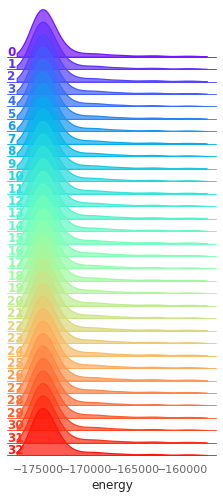

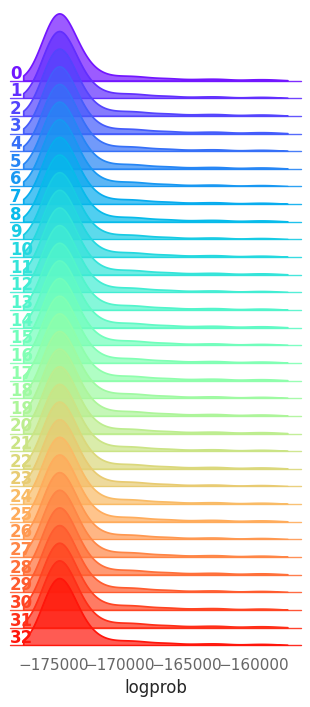

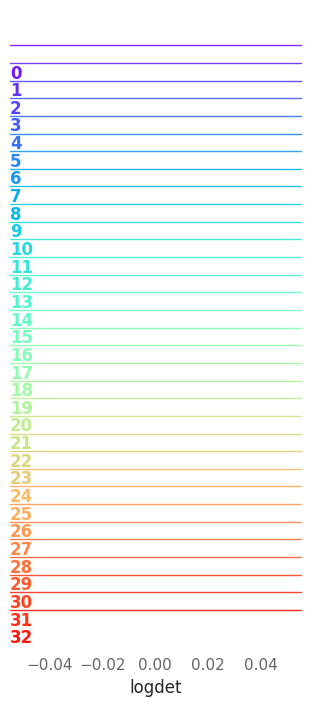

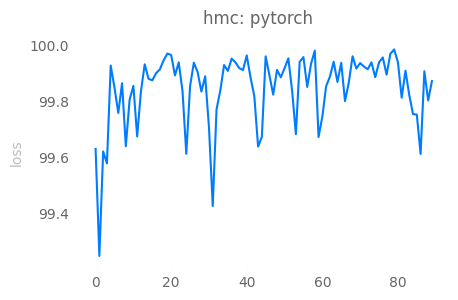

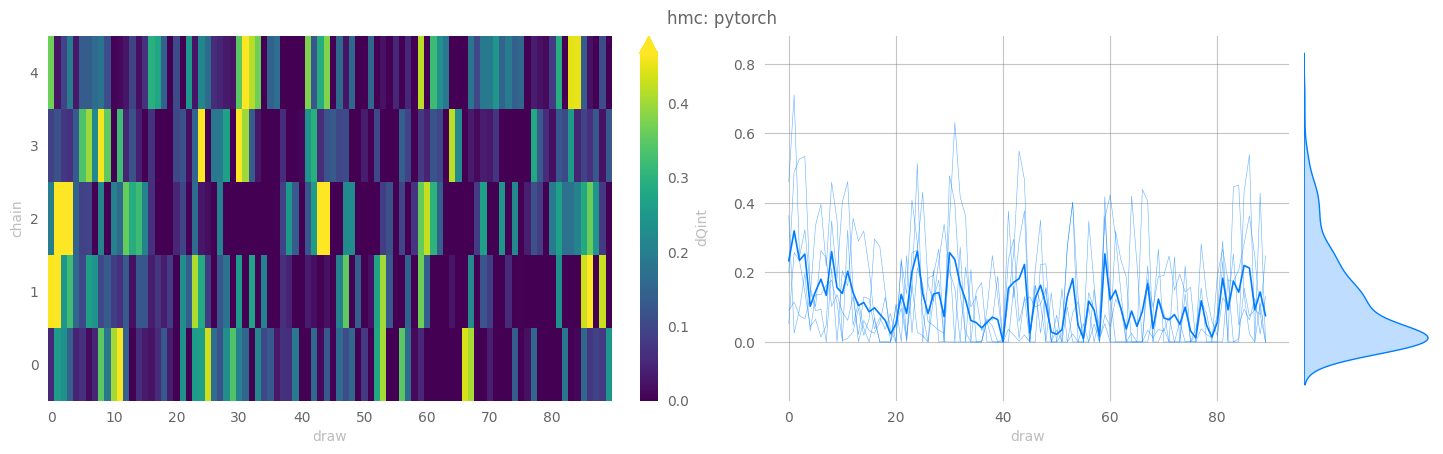

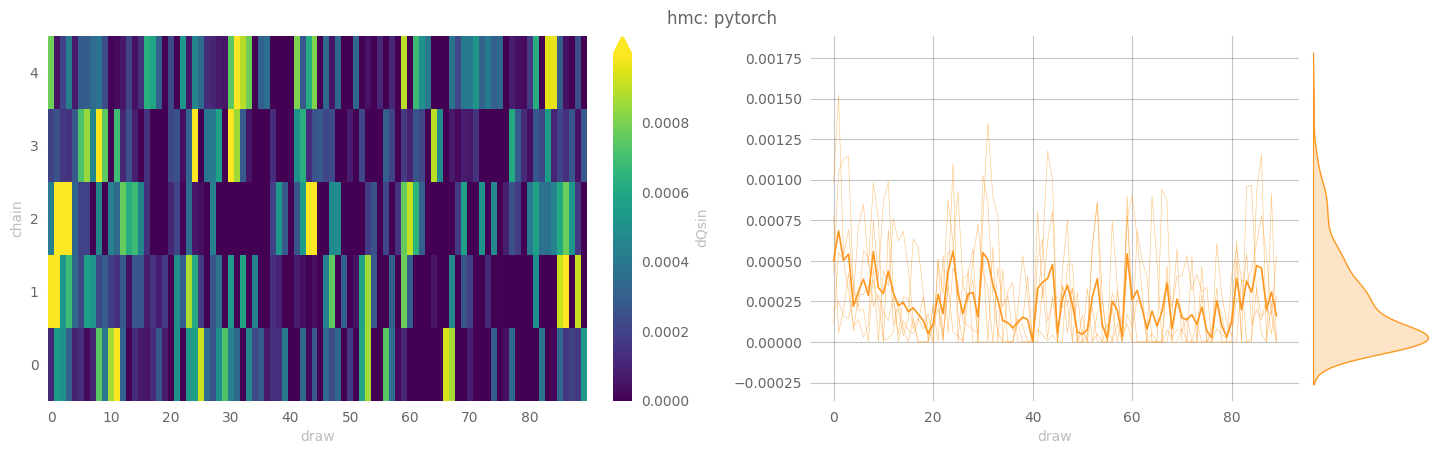

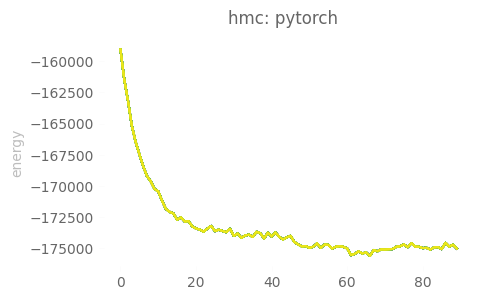

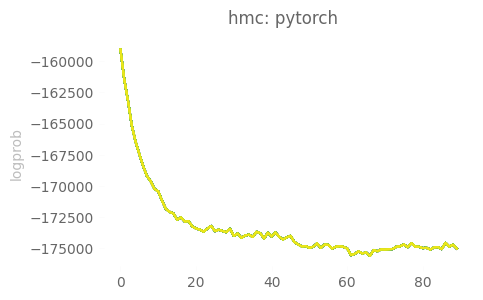

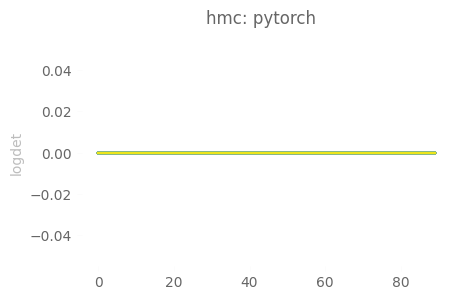

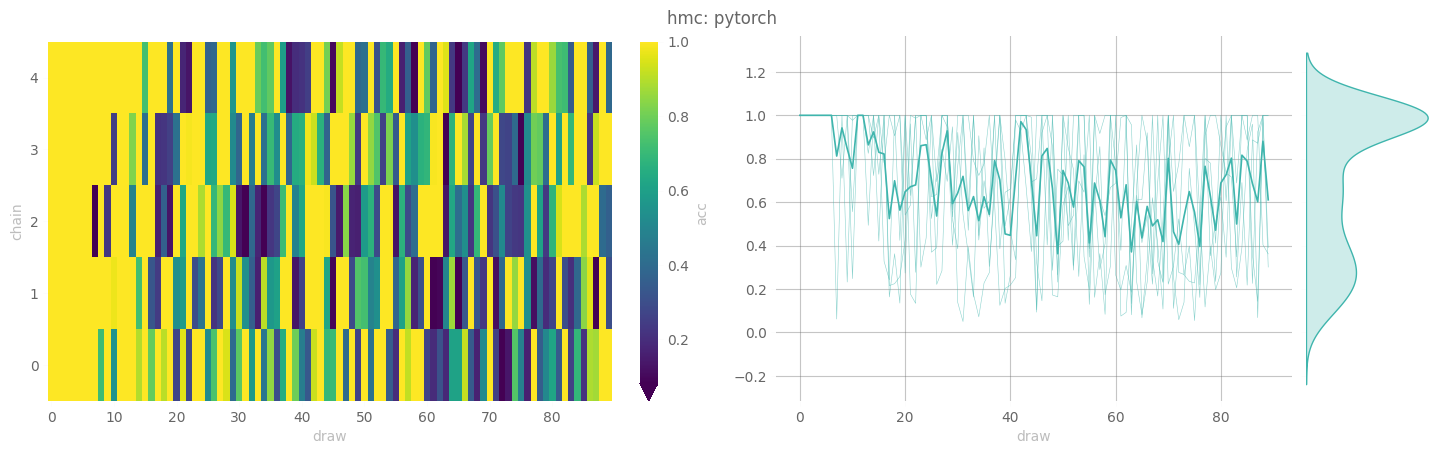

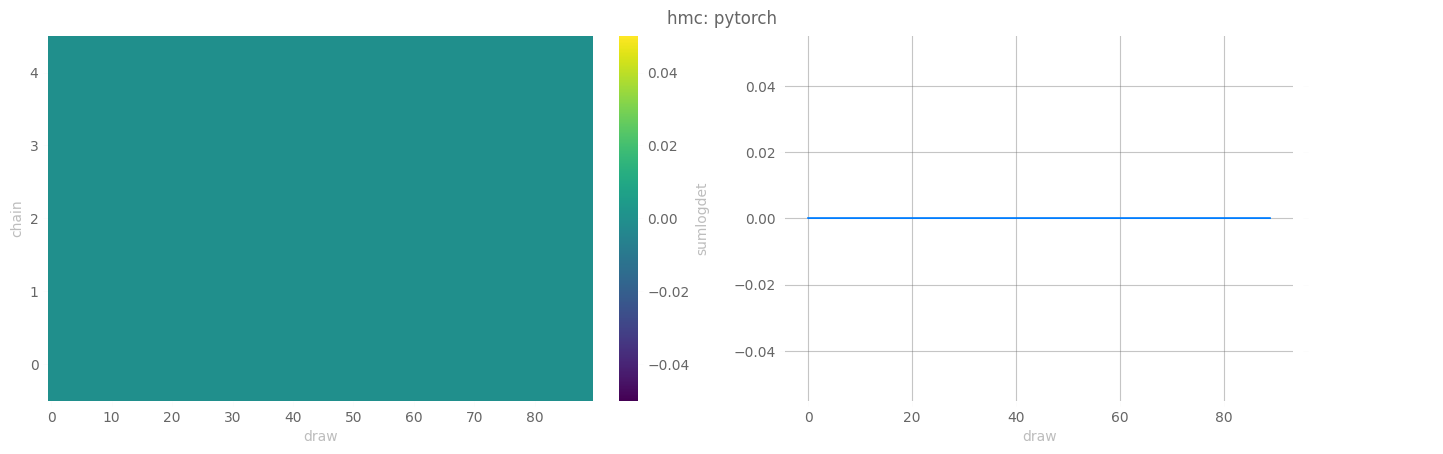

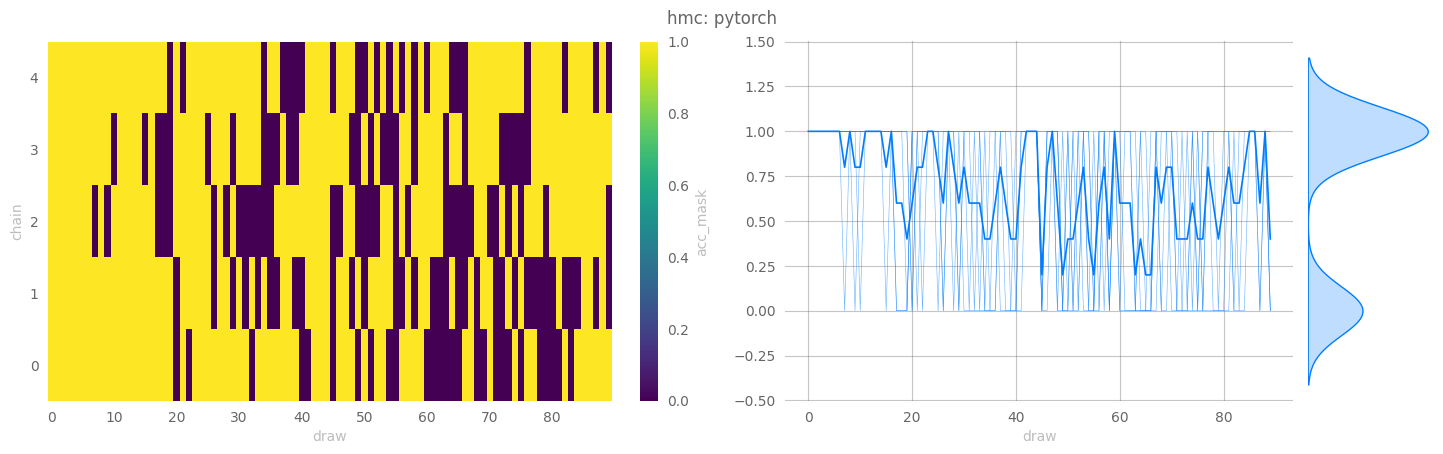

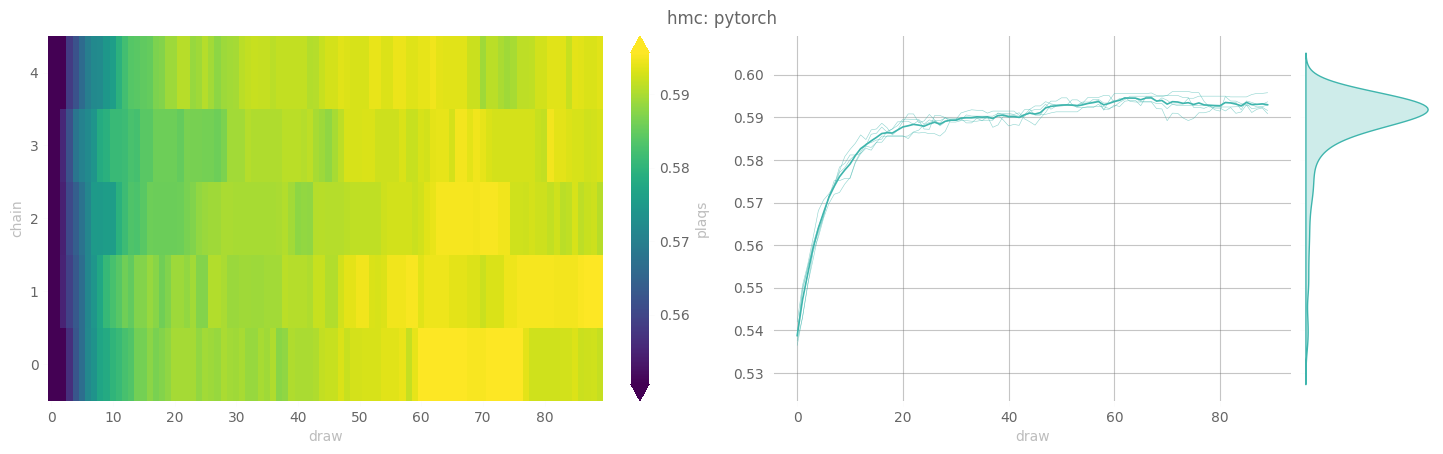

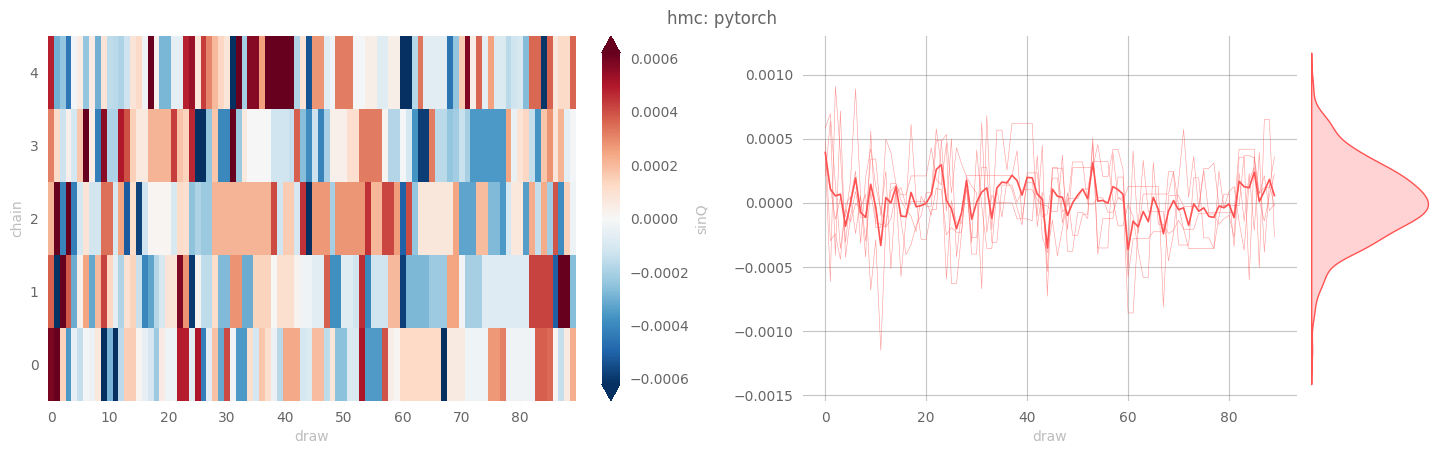

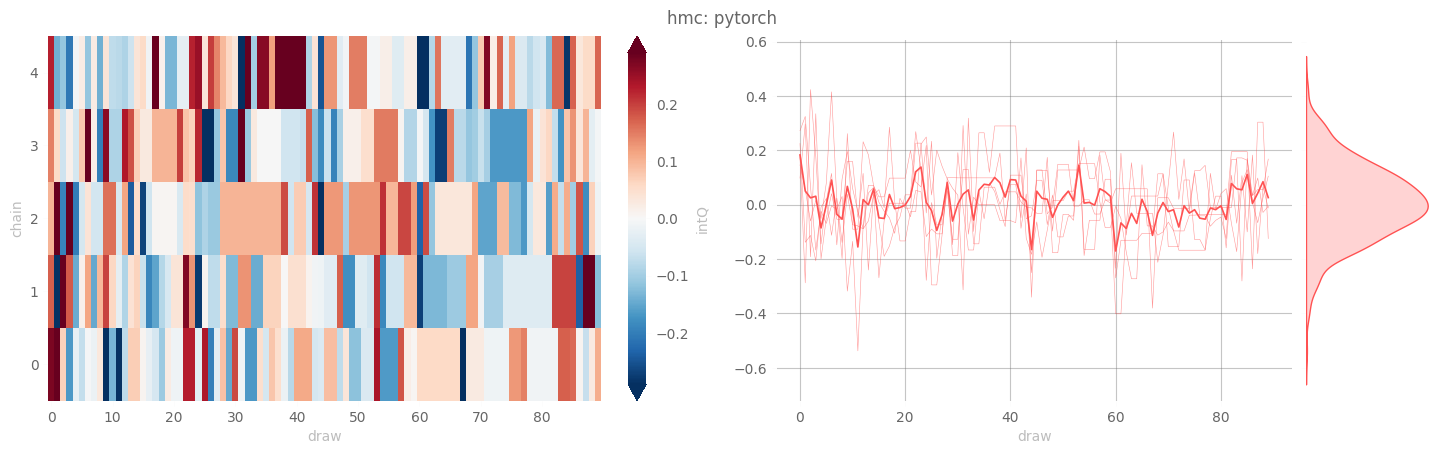

In [13]:
outputs_pt = ptExpSU3.evaluate(job_type='hmc', beta=6.0, eps=0.03125, nleapfrog=32, eval_steps=100)

11:44:08 WARNING  x.shape (original): (5, 294912)                                                         ]8;id=125270;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=555534;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#524\524]8;;\

         WARNING  x[:nchains].shape: (5, 294912)                                                          ]8;id=108100;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=881401;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#530\530]8;;\

11:44:13 INFO     step=0.00, beta=6.00, dt=4.14, hmc_step=0.00, loss=98.74, dQint=0.40, dQsin=0.00,       ]8;id=508770;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=857456;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-235.72, logprob=-235.72, logdet=0.00, acc=1.00, sumlogdet=0.00+0.00j,                         
                  acc_mask=1.00, plaqs=-0.00, sinQ=0.00, intQ=0.27                                                      

11:44:30 INFO     step=5.00, beta=6.00, dt=3.44, hmc_step=5.00, loss=99.85, dQint=0.15, dQsin=0.00,       ]8;id=856439;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=688276;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-137946.50, logprob=-137946.50, logdet=0.00, acc=1.00, sumlogdet=0.00+0.00j,                   
                  acc_mask=1.00, plaqs=0.47, sinQ=-0.00, intQ=-0.13                                                     

11:44:48 INFO     step=10.00, beta=6.00, dt=3.45, hmc_step=10.00, loss=99.84, dQint=0.15, dQsin=0.00,     ]8;id=267884;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=672182;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-159398.30, logprob=-159398.30, logdet=0.00, acc=1.00, sumlogdet=0.00+0.00j,                   
                  acc_mask=1.00, plaqs=0.54, sinQ=-0.00, intQ=-0.07                                                     

11:45:05 INFO     step=15.00, beta=6.00, dt=3.56, hmc_step=15.00, loss=99.76, dQint=0.18, dQsin=0.00,     ]8;id=200711;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=362124;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-167545.08, logprob=-167545.08, logdet=0.00, acc=1.00, sumlogdet=0.00+0.00j,                   
                  acc_mask=1.00, plaqs=0.57, sinQ=0.00, intQ=0.14                                                       

11:45:23 INFO     step=20.00, beta=6.00, dt=3.58, hmc_step=20.00, loss=99.81, dQint=0.08, dQsin=0.00,     ]8;id=113411;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=736791;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-170938.08, logprob=-170938.08, logdet=0.00, acc=0.65, sumlogdet=0.00+0.00j,                   
                  acc_mask=0.40, plaqs=0.58, sinQ=-0.00, intQ=-0.01                                                     

11:45:40 INFO     step=25.00, beta=6.00, dt=3.42, hmc_step=25.00, loss=99.88, dQint=0.13, dQsin=0.00,     ]8;id=734143;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=849284;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-172523.17, logprob=-172523.17, logdet=0.00, acc=0.65, sumlogdet=0.00+0.00j,                   
                  acc_mask=0.60, plaqs=0.59, sinQ=0.00, intQ=0.02                                                       

11:45:58 INFO     step=30.00, beta=6.00, dt=4.17, hmc_step=30.00, loss=99.89, dQint=0.12, dQsin=0.00,     ]8;id=164804;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=608608;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-173379.95, logprob=-173379.95, logdet=0.00, acc=0.83, sumlogdet=0.00+0.00j,                   
                  acc_mask=0.80, plaqs=0.59, sinQ=0.00, intQ=0.02                                                       

11:46:16 INFO     step=35.00, beta=6.00, dt=3.47, hmc_step=35.00, loss=99.91, dQint=0.11, dQsin=0.00,     ]8;id=952097;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=988809;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-174060.38, logprob=-174060.38, logdet=0.00, acc=0.70, sumlogdet=0.00+0.00j,                   
                  acc_mask=0.80, plaqs=0.59, sinQ=0.00, intQ=0.08                                                       

11:46:34 INFO     step=40.00, beta=6.00, dt=3.41, hmc_step=40.00, loss=99.90, dQint=0.09, dQsin=0.00,     ]8;id=282413;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=162368;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-174325.15, logprob=-174325.15, logdet=0.00, acc=0.67, sumlogdet=0.00+0.00j,                   
                  acc_mask=0.60, plaqs=0.59, sinQ=0.00, intQ=0.10                                                       

11:46:51 INFO     step=45.00, beta=6.00, dt=3.44, hmc_step=45.00, loss=99.91, dQint=0.16, dQsin=0.00,     ]8;id=889115;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=881306;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-174498.90, logprob=-174498.90, logdet=0.00, acc=0.44, sumlogdet=0.00+0.00j,                   
                  acc_mask=0.60, plaqs=0.59, sinQ=-0.00, intQ=-0.05                                                     

11:47:09 INFO     step=50.00, beta=6.00, dt=3.55, hmc_step=50.00, loss=99.88, dQint=0.11, dQsin=0.00,     ]8;id=755108;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=339203;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-174504.64, logprob=-174504.64, logdet=0.00, acc=0.77, sumlogdet=0.00+0.00j,                   
                  acc_mask=0.60, plaqs=0.59, sinQ=-0.00, intQ=-0.01                                                     

11:47:26 INFO     step=55.00, beta=6.00, dt=3.46, hmc_step=55.00, loss=99.86, dQint=0.13, dQsin=0.00,     ]8;id=832110;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=825218;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-175004.01, logprob=-175004.01, logdet=0.00, acc=0.79, sumlogdet=0.00+0.00j,                   
                  acc_mask=0.80, plaqs=0.59, sinQ=-0.00, intQ=-0.08                                                     

11:47:44 INFO     step=60.00, beta=6.00, dt=3.44, hmc_step=60.00, loss=99.98, dQint=0.02, dQsin=0.00,     ]8;id=468368;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=755692;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-174905.44, logprob=-174905.44, logdet=0.00, acc=0.29, sumlogdet=0.00+0.00j,                   
                  acc_mask=0.40, plaqs=0.59, sinQ=0.00, intQ=0.09                                                       

11:48:01 INFO     step=65.00, beta=6.00, dt=3.45, hmc_step=65.00, loss=99.89, dQint=0.11, dQsin=0.00,     ]8;id=74211;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=82304;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-175289.71, logprob=-175289.71, logdet=0.00, acc=0.60, sumlogdet=0.00+0.00j,                   
                  acc_mask=0.80, plaqs=0.59, sinQ=0.00, intQ=0.01                                                       

11:48:19 INFO     step=70.00, beta=6.00, dt=3.46, hmc_step=70.00, loss=99.96, dQint=0.01, dQsin=0.00,     ]8;id=414442;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=224552;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-175107.30, logprob=-175107.30, logdet=0.00, acc=0.31, sumlogdet=0.00+0.00j,                   
                  acc_mask=0.20, plaqs=0.59, sinQ=0.00, intQ=0.11                                                       

11:48:37 INFO     step=75.00, beta=6.00, dt=3.46, hmc_step=75.00, loss=99.86, dQint=0.02, dQsin=0.00,     ]8;id=50054;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=937984;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-174895.33, logprob=-174895.33, logdet=0.00, acc=0.46, sumlogdet=0.00+0.00j,                   
                  acc_mask=0.20, plaqs=0.59, sinQ=0.00, intQ=0.12                                                       

11:48:54 INFO     step=80.00, beta=6.00, dt=3.42, hmc_step=80.00, loss=99.96, dQint=0.00, dQsin=0.00,     ]8;id=300032;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=842428;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-175411.71, logprob=-175411.71, logdet=0.00, acc=0.56, sumlogdet=0.00+0.00j,                   
                  acc_mask=0.40, plaqs=0.59, sinQ=0.00, intQ=0.05                                                       

11:49:12 INFO     step=85.00, beta=6.00, dt=3.46, hmc_step=85.00, loss=99.91, dQint=0.06, dQsin=0.00,     ]8;id=39840;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=230048;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-174453.56, logprob=-174453.56, logdet=0.00, acc=0.47, sumlogdet=0.00+0.00j,                   
                  acc_mask=0.40, plaqs=0.59, sinQ=0.00, intQ=0.03                                                       

11:49:29 INFO     step=90.00, beta=6.00, dt=3.44, hmc_step=90.00, loss=99.89, dQint=0.11, dQsin=0.00,     ]8;id=531329;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=869921;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-174889.24, logprob=-174889.24, logdet=0.00, acc=0.35, sumlogdet=0.00+0.00j,                   
                  acc_mask=0.80, plaqs=0.59, sinQ=0.00, intQ=0.07                                                       

11:49:47 INFO     step=95.00, beta=6.00, dt=3.46, hmc_step=95.00, loss=99.96, dQint=0.01, dQsin=0.00,     ]8;id=91926;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py\trainer.py]8;;\:]8;id=831306;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/trainers/tensorflow/trainer.py#558\558]8;;\
                  energy=-174817.48, logprob=-174817.48, logdet=0.00, acc=0.34, sumlogdet=0.00+0.00j,                   
                  acc_mask=0.20, plaqs=0.59, sinQ=-0.00, intQ=-0.03                                                     

11:50:04 WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/notebooks ]8;id=978138;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/utils/plot_helpers.py\plot_helpers.py]8;;\:]8;id=984580;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/utils/plot_helpers.py#860\860]8;;\
                  /outputs/2022-08-23-113846/tensorflow/hmc/plots/ridgeplots/energy_ridgeplot.svg                       

11:50:10 WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/notebooks ]8;id=733360;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/utils/plot_helpers.py\plot_helpers.py]8;;\:]8;id=332383;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/utils/plot_helpers.py#860\860]8;;\
                  /outputs/2022-08-23-113846/tensorflow/hmc/plots/ridgeplots/logprob_ridgeplot.svg                      

11:50:16 WARNING  Saving figure to: /lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/notebooks ]8;id=320470;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/utils/plot_helpers.py\plot_helpers.py]8;;\:]8;id=990957;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/utils/plot_helpers.py#860\860]8;;\
                  /outputs/2022-08-23-113846/tensorflow/hmc/plots/ridgeplots/logdet_ridgeplot.svg                       

11:50:24 INFO     Saving dataset to: /lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/notebooks/outp ]8;id=483219;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py\common.py]8;;\:]8;id=69444;file:///lus/grand/projects/DLHMC/foremans/l2hmc-qcd/src/l2hmc/common.py#171\171]8;;\
                  uts/2022-08-23-113846/tensorflow/hmc/data/hmc_data.h5                                                 

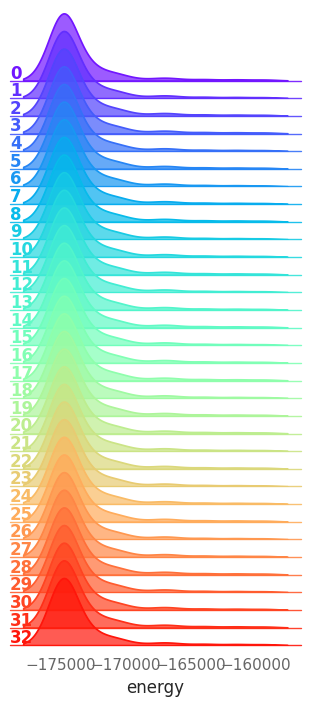

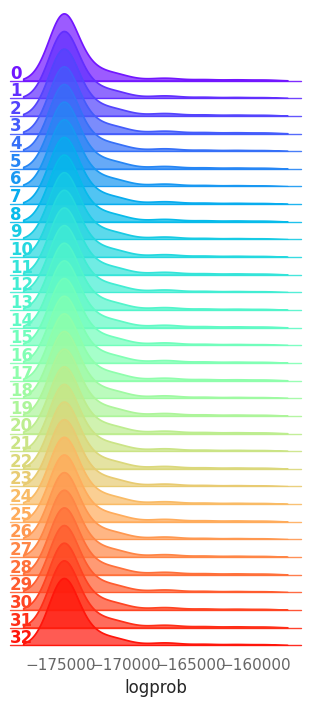

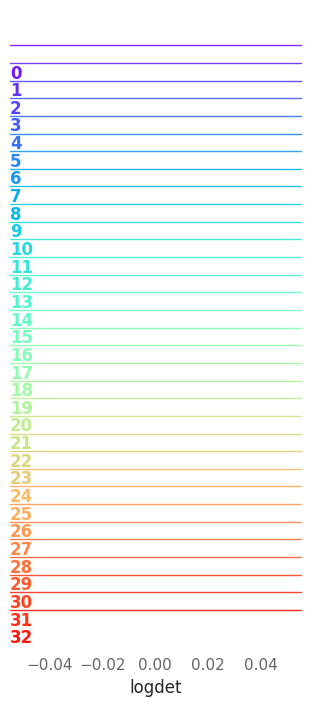

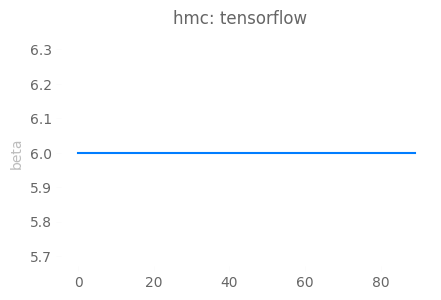

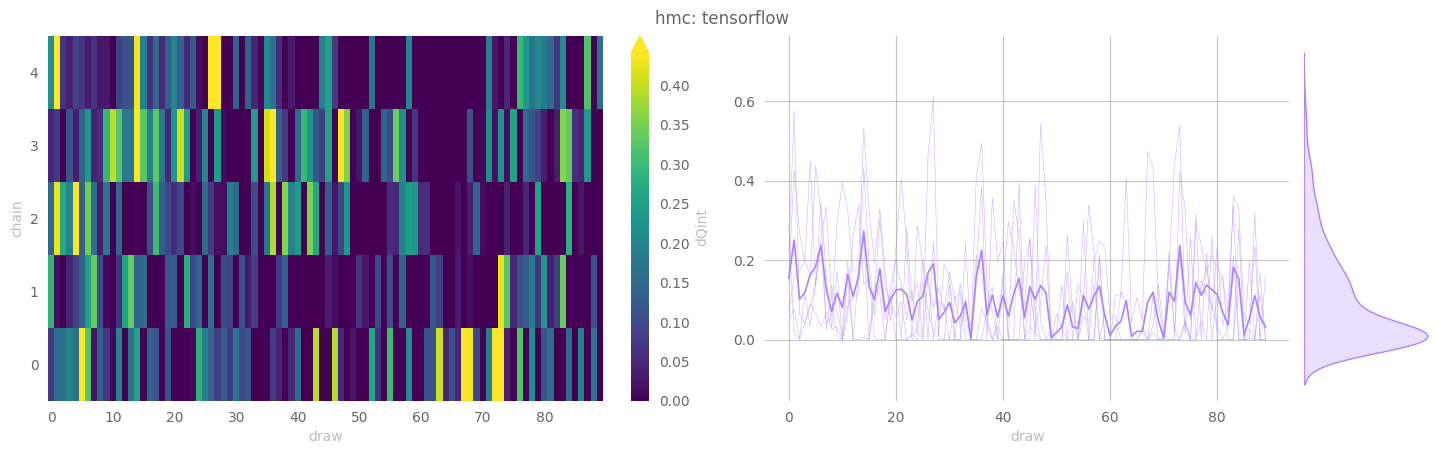

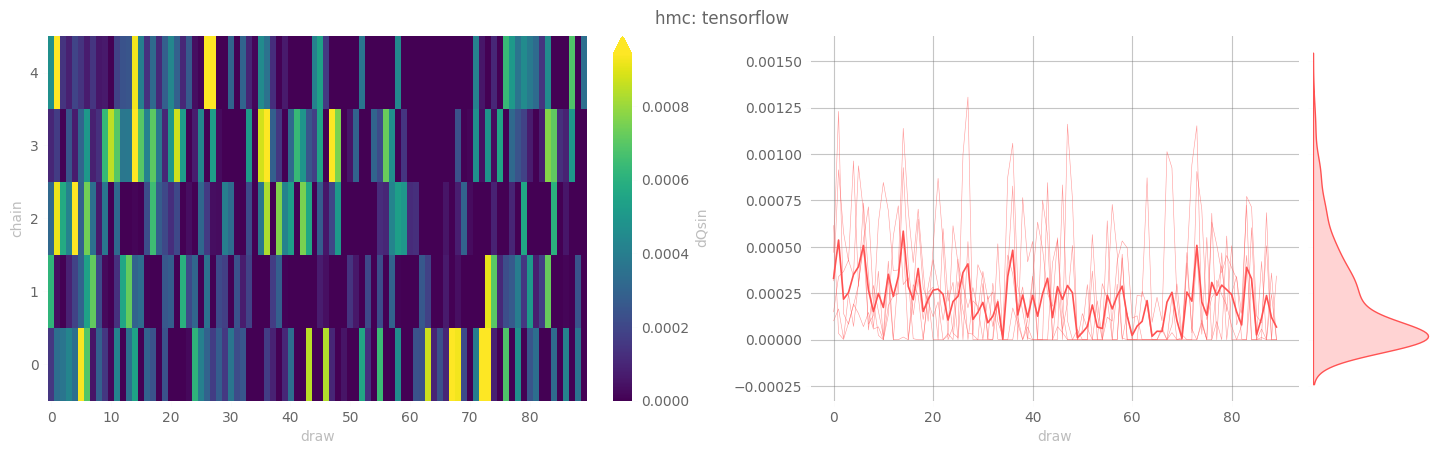

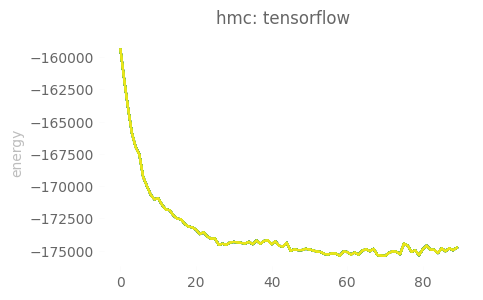

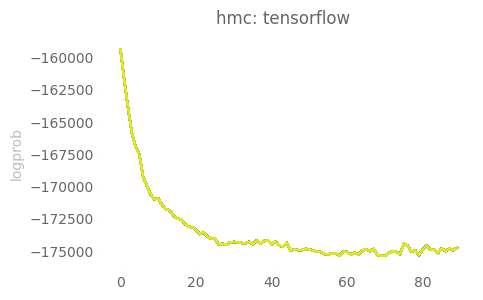

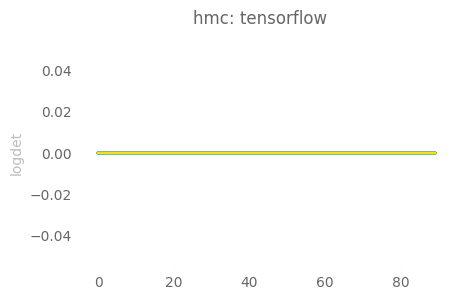

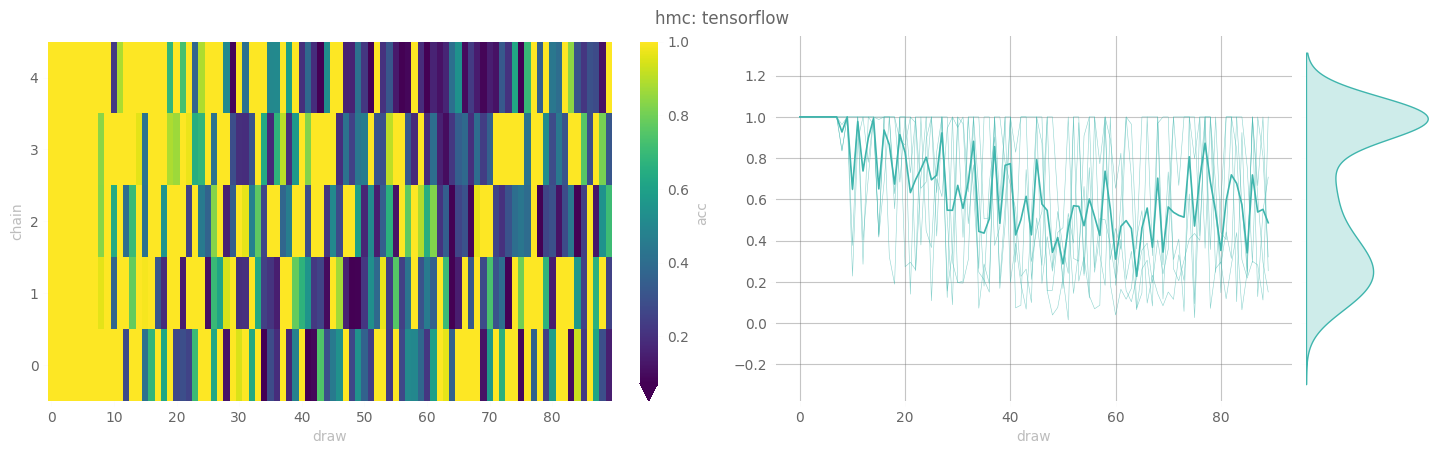

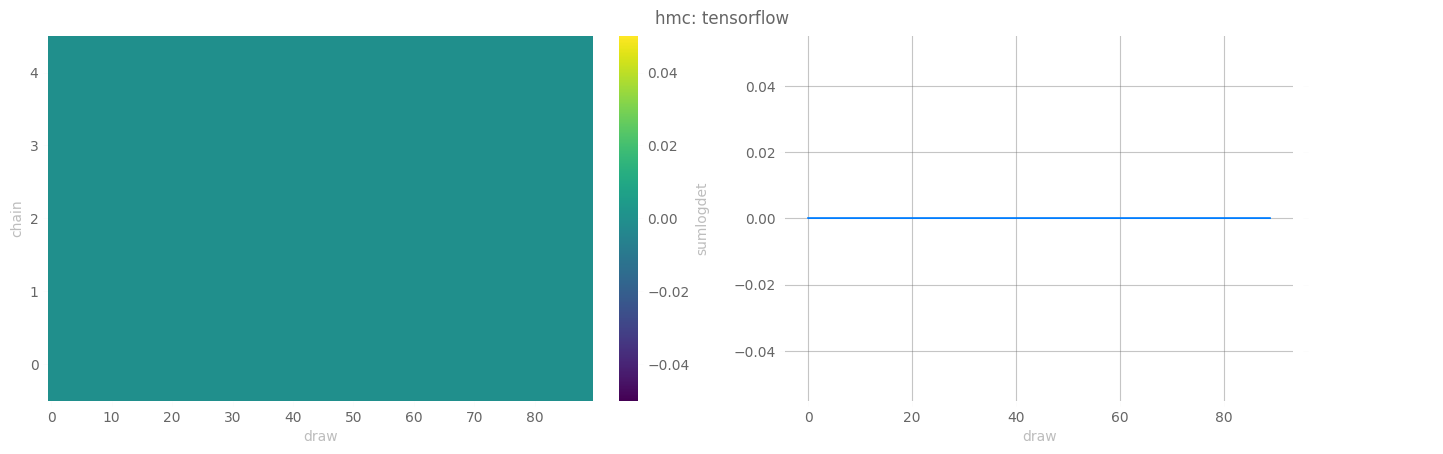

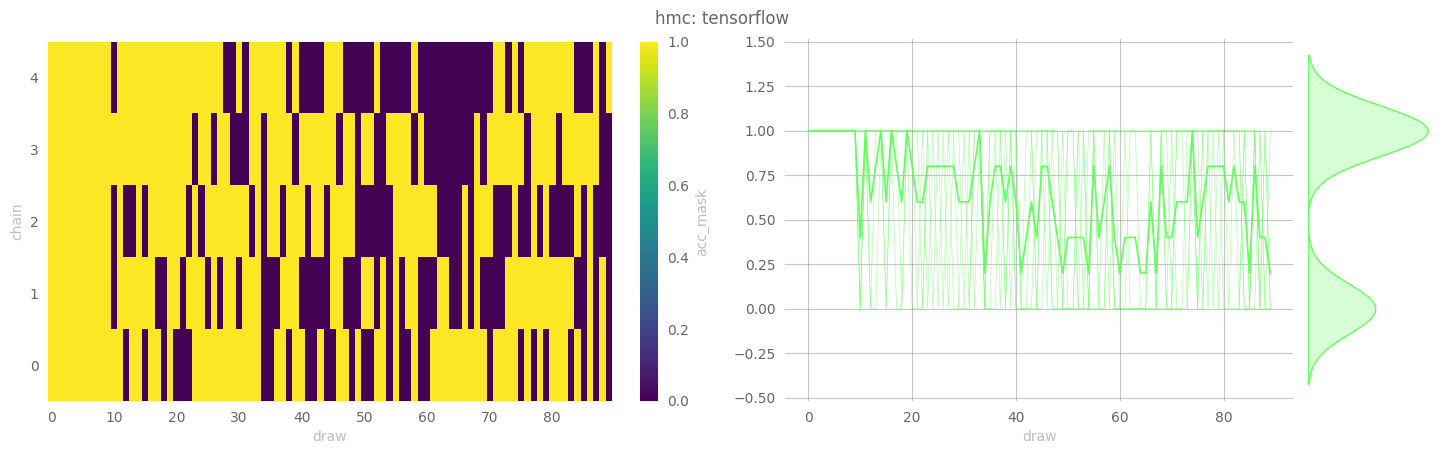

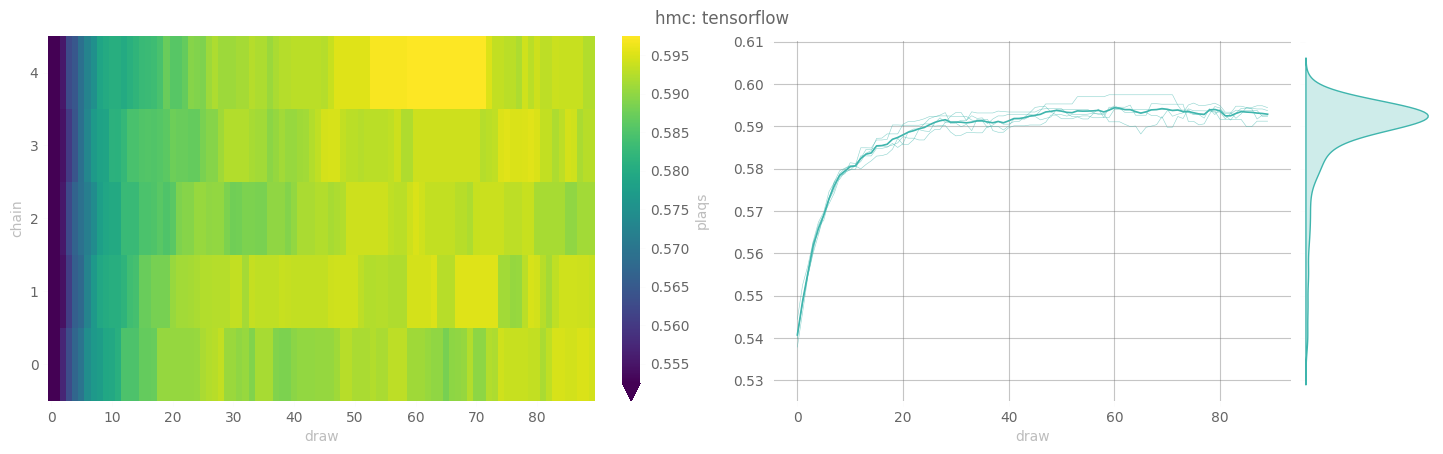

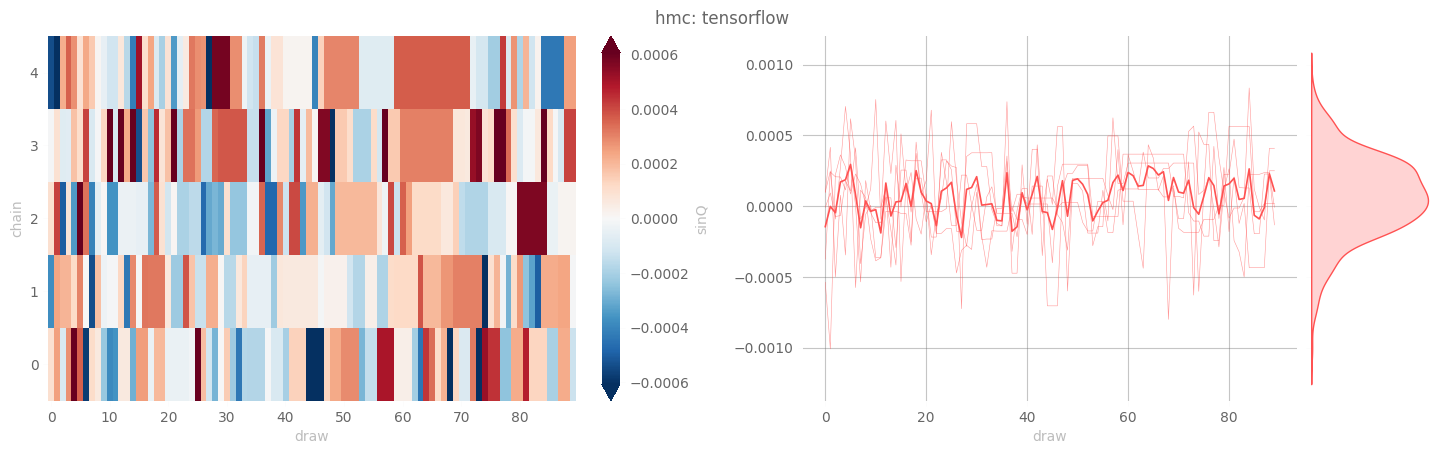

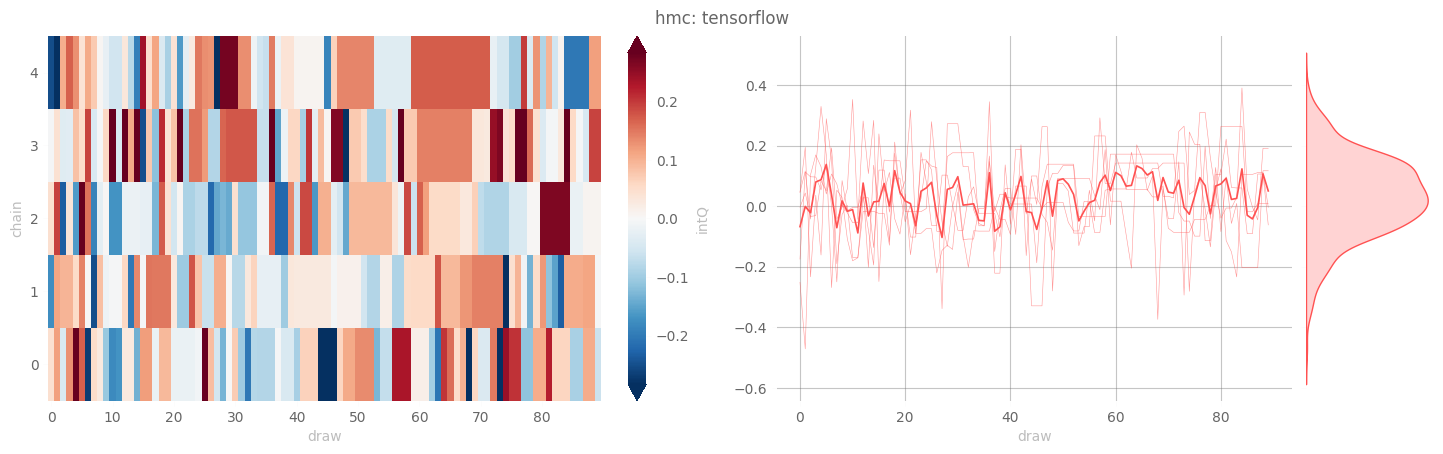

In [14]:
outputs_tf = tfExpSU3.evaluate(job_type='hmc', beta=6.0, eps=0.03125, nleapfrog=32, eval_steps=100)